In [ ]:
import sys
sys.path.append('../')

In [2]:
import torchxrayvision as xrv
# from torchxrayvision.datasets import COVID19_Dataset
from src.xrayvision import COVID19_Dataset
import torchvision

import torch
import pandas as pd

from tqdm.auto import tqdm, trange
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline

random.seed(19)
np.random.seed(19)
torch.manual_seed(19)

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve

In [4]:
from src.visualization import show_images

In [5]:
EXPORT = True

In [6]:
model = xrv.models.DenseNet(weights='all') # CheXpert (Stanford)
model = model.eval()

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

d_covid19 = COVID19_Dataset(
    '/Users/aniket/Google Drive/Projects/covid-research/data/covid-chestxray-dataset/images',
    '/Users/aniket/Google Drive/Projects/covid-research/data/covid-chestxray-dataset/metadata.csv',
    transform=transform
)

In [7]:
data_dict = {'Aspergillosis': {0.0: 534, 1.0: 1},
 'Aspiration': {0.0: 534, 1.0: 1},
 'Bacterial': {0.0: 487, 1.0: 48},
 'COVID-19': {0.0: 193, 1.0: 342},
 'Chlamydophila': {0.0: 534, 1.0: 1},
 'Fungal': {0.0: 512, 1.0: 23},
 'H1N1': {0.0: 534, 1.0: 1},
 'Herpes ': {0.0: 532, 1.0: 3},
 'Influenza': {0.0: 531, 1.0: 4},
 'Klebsiella': {0.0: 526, 1.0: 9},
 'Legionella': {0.0: 526, 1.0: 9},
 'Lipoid': {0.0: 527, 1.0: 8},
 'MERS-CoV': {0.0: 527, 1.0: 8},
 'MRSA': {0.0: 534, 1.0: 1},
 'Mycoplasma': {0.0: 530, 1.0: 5},
 'No Finding': {0.0: 520, 1.0: 15},
 'Nocardia': {0.0: 531, 1.0: 4},
 'Pneumocystis': {0.0: 513, 1.0: 22},
 'Pneumonia': {0.0: 26, 1.0: 509},
 'SARS': {0.0: 519, 1.0: 16},
 'Staphylococcus': {0.0: 534, 1.0: 1},
 'Streptococcus': {0.0: 518, 1.0: 17},
 'Tuberculosis': {0.0: 524, 1.0: 11},
 'Varicella': {0.0: 530, 1.0: 5},
 'Viral': {0.0: 157, 1.0: 378}}
table = pd.DataFrame.from_dict(data_dict);table

,Aspergillosis,Aspiration,Bacterial,COVID-19,Chlamydophila,Fungal,H1N1,Herpes,Influenza,Klebsiella,...,No Finding,Nocardia,Pneumocystis,Pneumonia,SARS,Staphylococcus,Streptococcus,Tuberculosis,Varicella,Viral
0.0,534,534,487,193,534,512,534,532,531,526,...,520,531,513,26,519,534,518,524,530,157
1.0,1,1,48,342,1,23,1,3,4,9,...,15,4,22,509,16,1,17,11,5,378


In [8]:
np.isnan(d_covid19[56]['intubated'])

True

In [9]:
d_covid19[random.randint(0, len(d_covid19))]

{'idx': 335,
 'lab': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1.], dtype=float32),
 'intubated': nan,
 'img': array([[[-532.6877 , -583.04865, -580.68427, ..., -576.04205,
          -577.40686, -531.8482 ],
         [-763.0932 , -814.43933, -817.7728 , ..., -831.5728 ,
          -832.1598 , -766.07825],
         [-769.4719 , -850.18835, -862.8646 , ..., -831.8141 ,
          -788.3016 , -713.03986],
         ...,
         [ 297.77124,  377.56723,  395.23657, ...,  223.7607 ,
           274.84937,  180.15999],
         [ 329.36517,  415.6304 ,  374.44904, ...,  207.21921,
           212.50743,  244.61526],
         [ 408.73993,  400.93616,  363.7805 , ...,  236.09398,
           207.90071,  281.96735]]], dtype=float32)}

# predict whether intubation required in case of any chest problem
## Create features

In [10]:
images = []
intubation_labels = []
for i in trange(len(d_covid19)):
    sample = d_covid19[i]
    image = sample['img']
    intubated = sample['intubated']
    
    if intubated in ('Y', 'N'):
        images.append(image)
        intubation_labels.append(intubated)
#     if i > 50:
#         break

## generated image embeddings

In [11]:
with torch.no_grad():
    X = []

    avg_pool = torch.nn.AvgPool2d((7, 7))
    for image in tqdm(images):
        image = torch.from_numpy(image)
        image = image.expand(1, 1, 224, 224)
        features = model.features(image)
        #print(features.shape)
        features = avg_pool(features)
        #print(features.shape)
        X.append(features.numpy().reshape(1024))
    X = np.asarray(X)

In [12]:
label_map = {'Y': 1, 'N': 0}
Y = np.asarray([[label_map[e]] for e in intubation_labels])

## Split train test

In [13]:
data = {}
split_pct = 0.75
total = len(X)
idx = list(range(len(X)))
random.shuffle(idx)

train_idx = idx[:int(total*split_pct)]
test_idx = idx[int(total*split_pct):]

data['train'] = X[train_idx], Y[train_idx]
data['test'] = X[test_idx], Y[test_idx]

data['info'] = {
    'train': {   
        'train_count': len(train_idx),
        'train_pos': np.sum(Y[train_idx]==1),
        'train_neg': np.sum(Y[train_idx]==0)   
    },
    'test': {
        'test_count': len(test_idx),
        'test_pos': np.sum(Y[test_idx]==1),
        'test_neg': np.sum(Y[test_idx]==0),   
    }
}

In [14]:
data['info']

{'train': {'train_count': 119, 'train_pos': 60, 'train_neg': 59},
 'test': {'test_count': 40, 'test_pos': 26, 'test_neg': 14}}

## Train models

In [15]:
for i in range(2, 14):
    knn = KNeighborsClassifier(i)
    knn.fit(*data['train'])
    print(f'{i} train test score: ', knn.score(*data['train']), knn.score(*data['test']))

    y_true = data['test'][1]
    y_pred = knn.predict(data['test'][0])

    print('precision-recall: ', precision_score(y_true, y_pred), recall_score(y_true, y_pred))
    print('-'*50)

2 train test score:  0.8739495798319328 0.725
precision-recall:  0.8947368421052632 0.6538461538461539
--------------------------------------------------
3 train test score:  0.8571428571428571 0.775
precision-recall:  0.8695652173913043 0.7692307692307693
--------------------------------------------------
4 train test score:  0.8319327731092437 0.75
precision-recall:  0.8636363636363636 0.7307692307692307
--------------------------------------------------
5 train test score:  0.8151260504201681 0.75
precision-recall:  0.8333333333333334 0.7692307692307693
--------------------------------------------------
6 train test score:  0.7647058823529411 0.75
precision-recall:  0.8636363636363636 0.7307692307692307
--------------------------------------------------
7 train test score:  0.8151260504201681 0.75
precision-recall:  0.8333333333333334 0.7692307692307693
--------------------------------------------------
8 train test score:  0.7983193277310925 0.7
precision-recall:  0.818181818181818

In [16]:
knn = KNeighborsClassifier(5)
knn.fit(*data['train'])

KNeighborsClassifier()

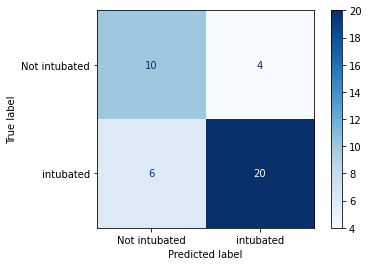

In [17]:
plot_confusion_matrix(
    knn,
    data['test'][0],
    data['test'][1],
    labels=(0, 1),
    display_labels = ('Not intubated', 'intubated'),
    cmap=plt.cm.Blues
)
if EXPORT:
    plt.savefig('../images/intubation_cmat.svg')
plt.show()

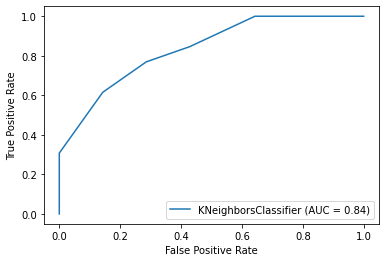

In [18]:
plot_roc_curve(
    knn,
    *data['test']

)
if EXPORT:
    plt.savefig('../images/intubation-roc-curve.png')
plt.show()

## ROC CI

## bootstrap
credits: https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

In [46]:
from scipy.stats import sem

# y_pred = np.array([0.21, 0.32, 0.63, 0.35, 0.92, 0.79, 0.82, 0.99, 0.04])
# y_true = np.array([0,    1,    0,    0,    1,    1,    0,    1,    0   ])
y_pred = knn.predict(data['test'][0])
y_true = data['test'][1].reshape(len(y_pred))


print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 10000
rng_seed = 19  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.742
Bootstrap #1 ROC area: 0.788
Bootstrap #2 ROC area: 0.717
Bootstrap #3 ROC area: 0.774
Bootstrap #4 ROC area: 0.678
Bootstrap #5 ROC area: 0.652
Bootstrap #6 ROC area: 0.646
Bootstrap #7 ROC area: 0.715
Bootstrap #8 ROC area: 0.656
Bootstrap #9 ROC area: 0.793
Bootstrap #10 ROC area: 0.602
Bootstrap #11 ROC area: 0.642
Bootstrap #12 ROC area: 0.657
Bootstrap #13 ROC area: 0.787
Bootstrap #14 ROC area: 0.708
Bootstrap #15 ROC area: 0.868
Bootstrap #16 ROC area: 0.827
Bootstrap #17 ROC area: 0.718
Bootstrap #18 ROC area: 0.607
Bootstrap #19 ROC area: 0.830
Bootstrap #20 ROC area: 0.583
Bootstrap #21 ROC area: 0.834
Bootstrap #22 ROC area: 0.758
Bootstrap #23 ROC area: 0.718
Bootstrap #24 ROC area: 0.720
Bootstrap #25 ROC area: 0.617
Bootstrap #26 ROC area: 0.792
Bootstrap #27 ROC area: 0.833
Bootstrap #28 ROC area: 0.863
Bootstrap #29 ROC area: 0.771
Bootstrap #30 ROC area: 0.854
Bootstrap #31 ROC area: 0.813
Bootstrap #32 ROC area: 0.869
Bootstrap #33 ROC area: 

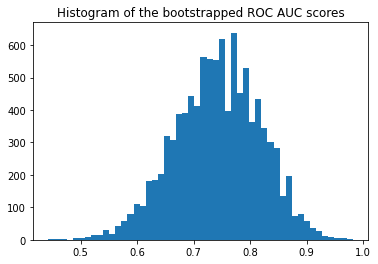

In [47]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [48]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))


Confidence interval for the score: [0.615 - 0.863]
